In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import KFold

# load Food-101 dataset (train only)
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

# get classes names
class_names = info.features['label'].names[:10]

# Filtering dataset to get only the first 10 classes
def filter_classes(image, label):
    return tf.reduce_any([label == i for i in range(10)])

filtered_dataset = dataset.filter(filter_classes)

# Preprocessing of images
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label

# Apply preprocessing
filtered_dataset = filtered_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Converting dataset into a Numpy array for Kfold
def dataset_to_numpy(dataset):
    images, labels = [], []
    for image, label in dataset:
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

images, labels = dataset_to_numpy(filtered_dataset)

# Kfold
k = 5  # numbers of folds
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# list to save results
accuracy_per_fold = []
loss_per_fold = []
history_dicts = []


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.65SFR2_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.65SFR2_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [2]:
# Cnn model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu', input_shape=(224, 224, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPooling2D((2, batch2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation="relu", kernel_initializer='he_normal'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(class_names), activation="softmax", kernel_initializer='he_normal')
    ])
    model.compile(optimizer='Adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [3]:
fold_no = 1
for train_idx, val_idx in kfold.split(images, labels):
    train_images, val_images = images[train_idx], images[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Creation of the model
    model = create_model()

    # fitting
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), verbose=1,
                       callbacks=[
                           tf.keras.callbacks.ModelCheckpoint(filepath=f'model_fold_{fold_no}.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
                           tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
                       ])

    # Evaluation
    test_loss, test_acc = model.evaluate(val_images, val_labels)
    accuracy_per_fold.append(test_acc)
    loss_per_fold.append(test_loss)
    history_dicts.append(history.history)

    print(f'Fold {fold_no} - Accuracy: {test_acc * 100:.2f}% - Loss: {test_loss:.4f}')
    fold_no += 1

# average results
print(f'\nAverage Accuracy: {np.mean(accuracy_per_fold) * 100:.2f}%')
print(f'Average Loss: {np.mean(loss_per_fold):.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1185 - loss: 42.7736
Epoch 1: val_loss improved from inf to 2.15356, saving model to model_fold_1.weights.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 34s 100ms/step - accuracy: 0.1186 - loss: 42.6032 - val_accuracy: 0.1613 - val_loss: 2.1536 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1693 - loss: 2.1499
Epoch 2: val_loss improved from 2.15356 to 2.07006, saving model to model_fold_1.weights.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1693 - loss: 2.1499 - val_accuracy: 0.1880 - val_loss: 2.0701 - learning_rate: 0.0010
Epoch 3/10
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1967 - loss: 2.0707
Epoch 3: val_loss improved from 2.07006 to 2.04003, saving model to model_fold_1.weights.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1967 - loss: 2.0706 - val_accuracy: 0.2247 - val_loss: 2.0400 - learning_rate: 0.0010
Epoch 4/10
186/188 ━━━━━━━━━━━━━━━━━━

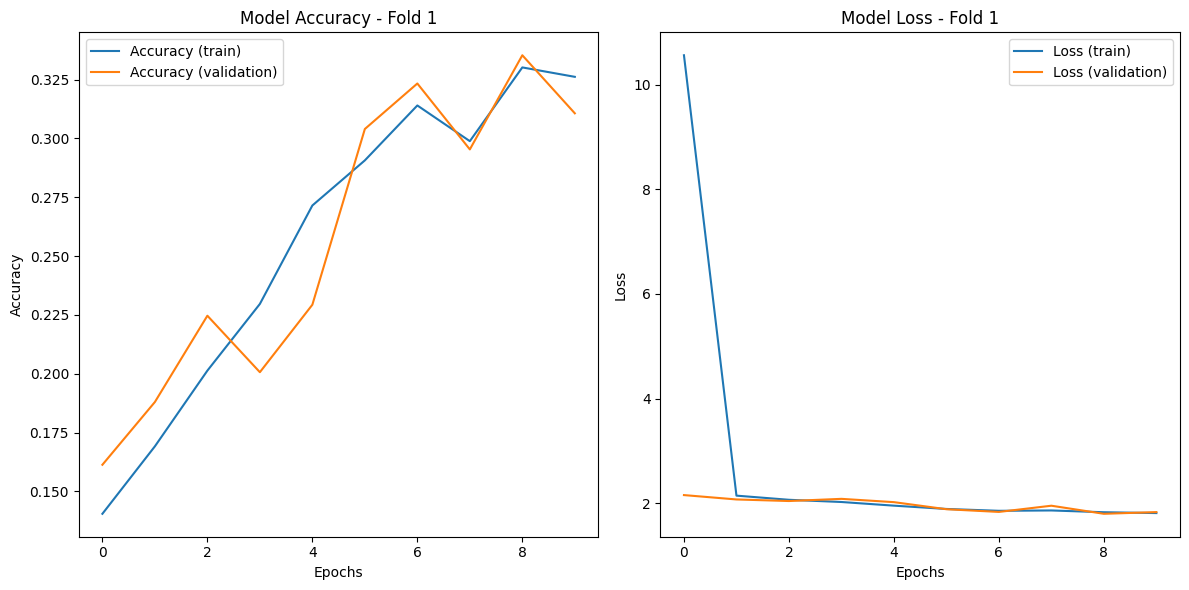

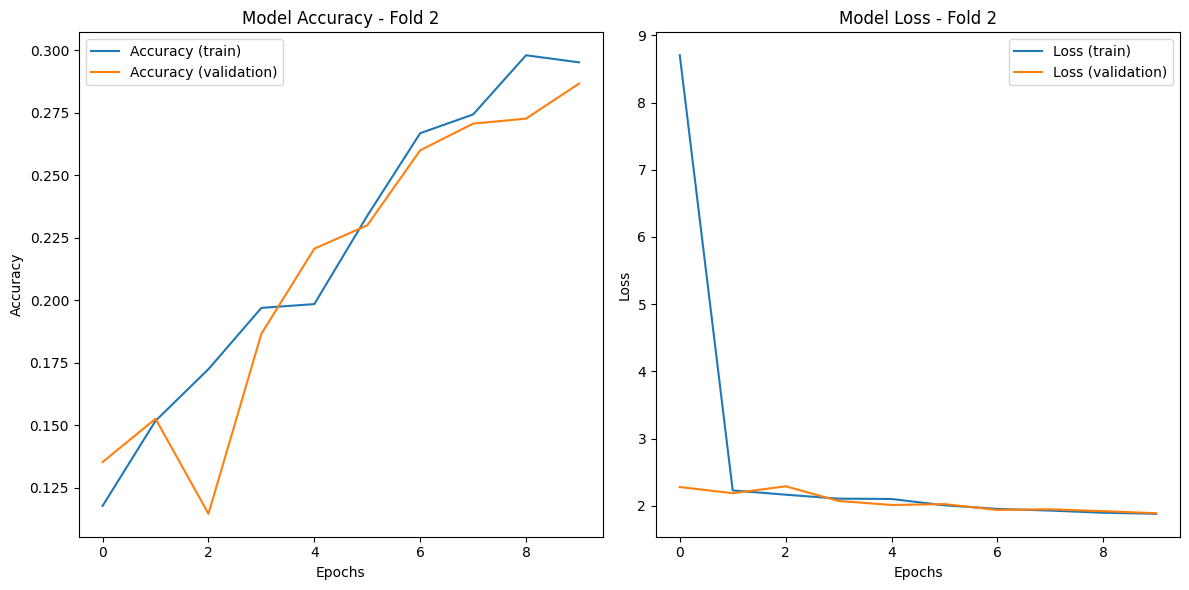

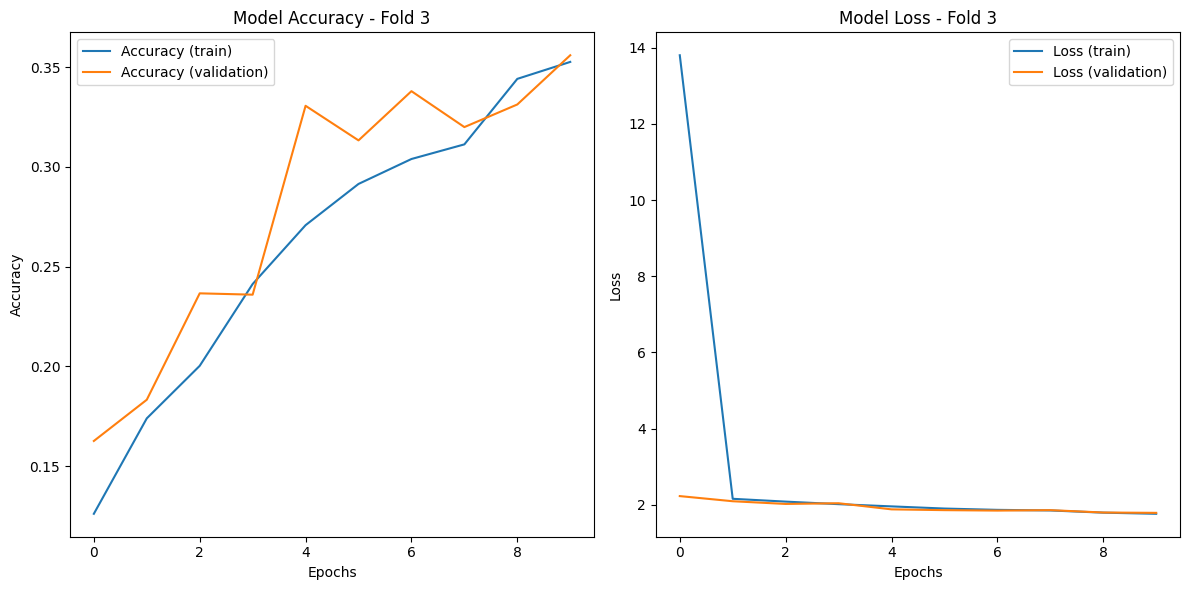

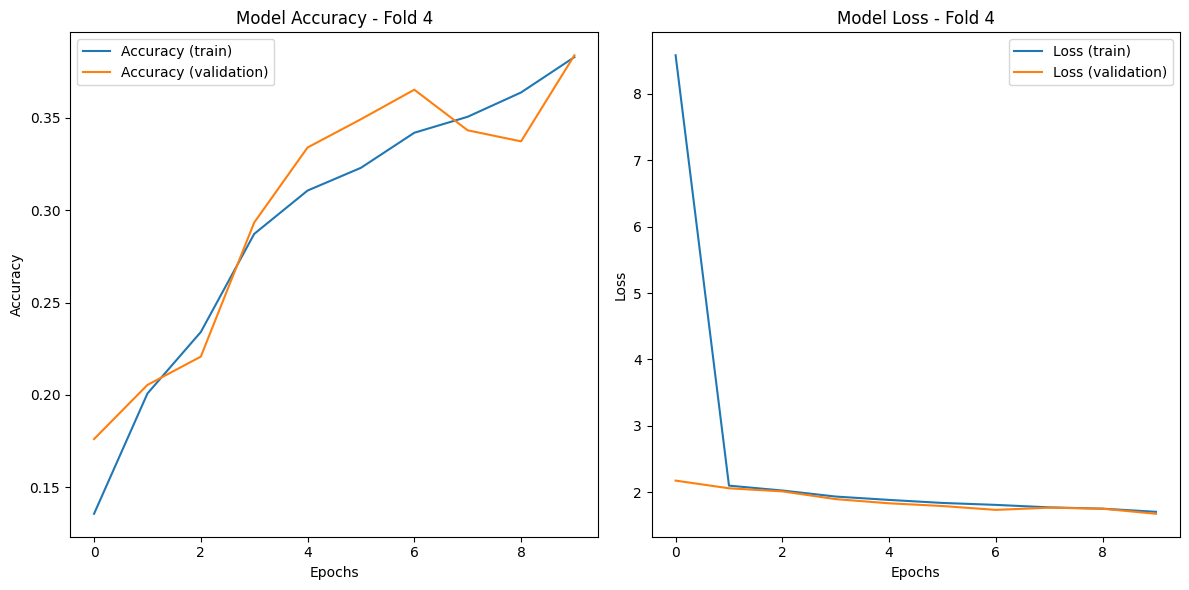

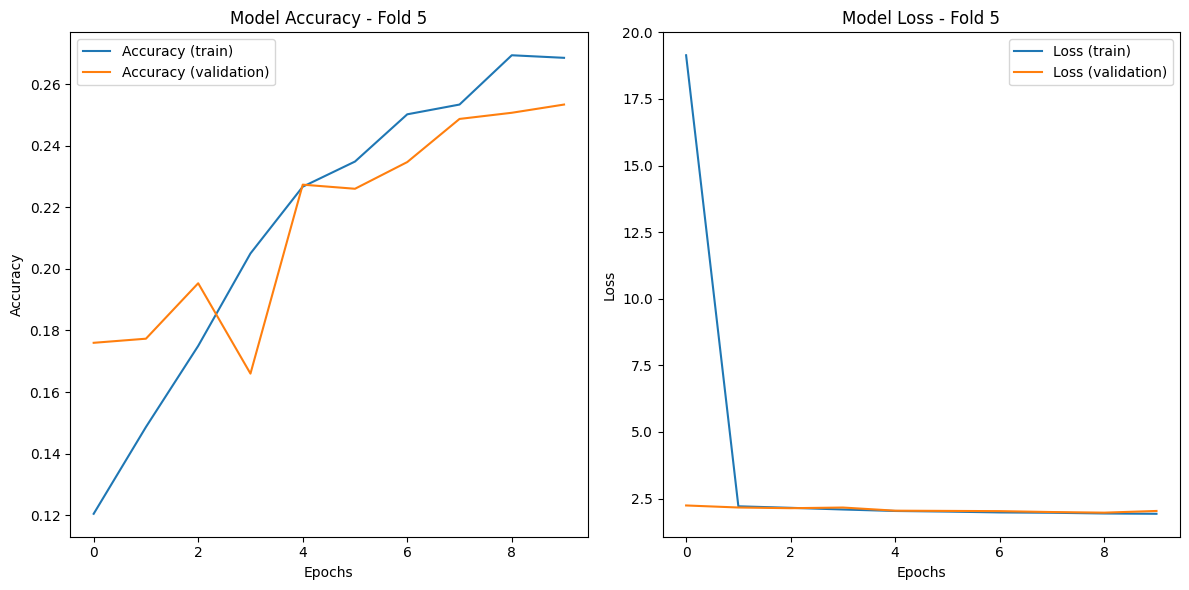

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Plotting of accuracy and loss for each fold
for i, history_dict in enumerate(history_dicts):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    plt.figure(figsize=(12, 6))

    # Accuracy graph
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Accuracy (train)')
    plt.plot(val_acc, label='Accuracy (validation)')
    plt.title(f'Model Accuracy - Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss graph
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Loss (train)')
    plt.plot(val_loss, label='Loss (validation)')
    plt.title(f'Model Loss - Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# Classfification report
y_pred_probs = model.predict(val_images)
y_pred = np.argmax(y_pred_probs, axis=1)
print("Classification Report:")
print(classification_report(val_labels, y_pred, target_names=class_names, digits=4))

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Classification Report:
                   precision    recall  f1-score   support

        apple_pie     0.0000    0.0000    0.0000       149
   baby_back_ribs     0.3048    0.6531    0.4156       147
          baklava     0.0000    0.0000    0.0000       162
   beef_carpaccio     0.5294    0.1200    0.1957       150
     beef_tartare     0.1923    0.0311    0.0535       161
       beet_salad     0.3830    0.1277    0.1915       141
         beignets     0.2793    0.6643    0.3932       140
         bibimbap     0.2379    0.6405    0.3469       153
    bread_pudding     0.1558    0.1752    0.1649       137
breakfast_burrito     0.1481    0.1500    0.1491       160

         accuracy                         0.2507      1500
        macro avg     0.2231    0.2562    0.1910      1500
     weighted avg     0.2198    0.2507    0.1871      1500



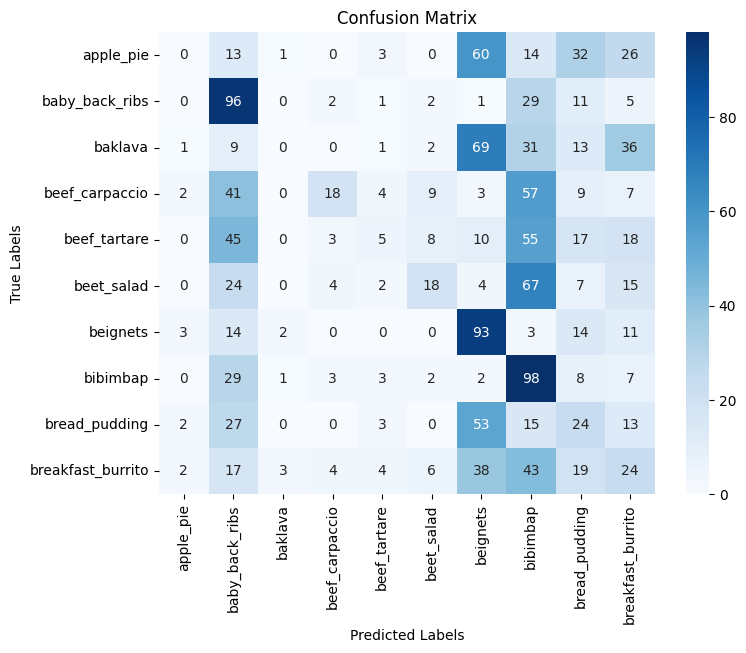

In [6]:
# Confusion Matrix for the last fold
cm = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()